# String Simulation Analysis

This notebook will help you analyse the convergence of the string-method and if you are lucky extract a nice free energy surface. 

In [1]:
import numpy as np
import glob as glob
from math import ceil
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import pickle
import logging
import sys
import os

sys.path.append("../../string-method-gmxapi/")
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyemma").setLevel(logging.NOTSET)

In [48]:
%load_ext lab_black
logging.getLogger("blib2to3.pgen2.driver").setLevel(logging.WARNING)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [61]:
def colorbar(mappable, cmap, norm, label0, size=10):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    cbar.set_label(label0, size=size)
    return cbar

In [13]:
plt.rcParams["axes.facecolor"] = "#f9f9fb"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams["lines.solid_capstyle"] = "round"

In [4]:
def natural_sort(l):
    """
    Takes as input a list l of strings and sorts it with natural order.
      Parameters
      ----------
      l: list of strings.
      Returns
      -------
      l sorted
    """
    from re import split

    assert isinstance(l, list), "l is not a list!"
    for i in l:
        assert isinstance(i, str), "List contains non-string elements."
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [97]:
%load_ext autoreload

In [98]:
%autoreload 2

# String Convergence Analysis
## Extract CVs

In the cell bellow you can select which will be the simulation directory (in case this notebook is elsewhere). If the notebook is in the simulation directory just leave it as ".".

In [5]:
simulation_directory = "../../../KcsA_lb_v0_34"
os.chdir(simulation_directory)
os.getcwd()

'/data/sperez/Projects/string_simulations/KcsA_lb_v0_34'

Load the strings in the `strings` variable.

In [6]:
files = natural_sort(glob.glob("./strings/string*txt"))

In [7]:
strings = np.array([np.loadtxt(file).T for file in files])

In [8]:
with open("cv.pkl", "rb") as file:
    cvs, ndx_groups = pickle.load(file)

In [11]:
print("String details")
print("")
print(f"Number of string: {strings.shape[0]}")
print(f"Number of cvs: {strings.shape[1]}")
print(f"Number of beads per string: {strings.shape[2]}")

String details

Number of string: 159
Number of cvs: 8
Number of beads per string: 34


# Analyze string convergence
In these next plots you will be able to study the convergence of the string. At convergence the strings should be oscillating around an equilibrium position and not drift over the different iterations.

## Strings as a function of time
In this plot we can see the evolution of each string CV as function of the timeration number separatelly.

You can change two parameters in these plots the `start_iteration` before which all data is not plotted and the `n_average` which is the number of strings iterations to average in one block of strings. This is done in order to cancel some of the noisyness in the representation, to reduce the number of strings in the plot and to see more clearly if there is average drift.

+ borrar último string
+ probar con el GPCR

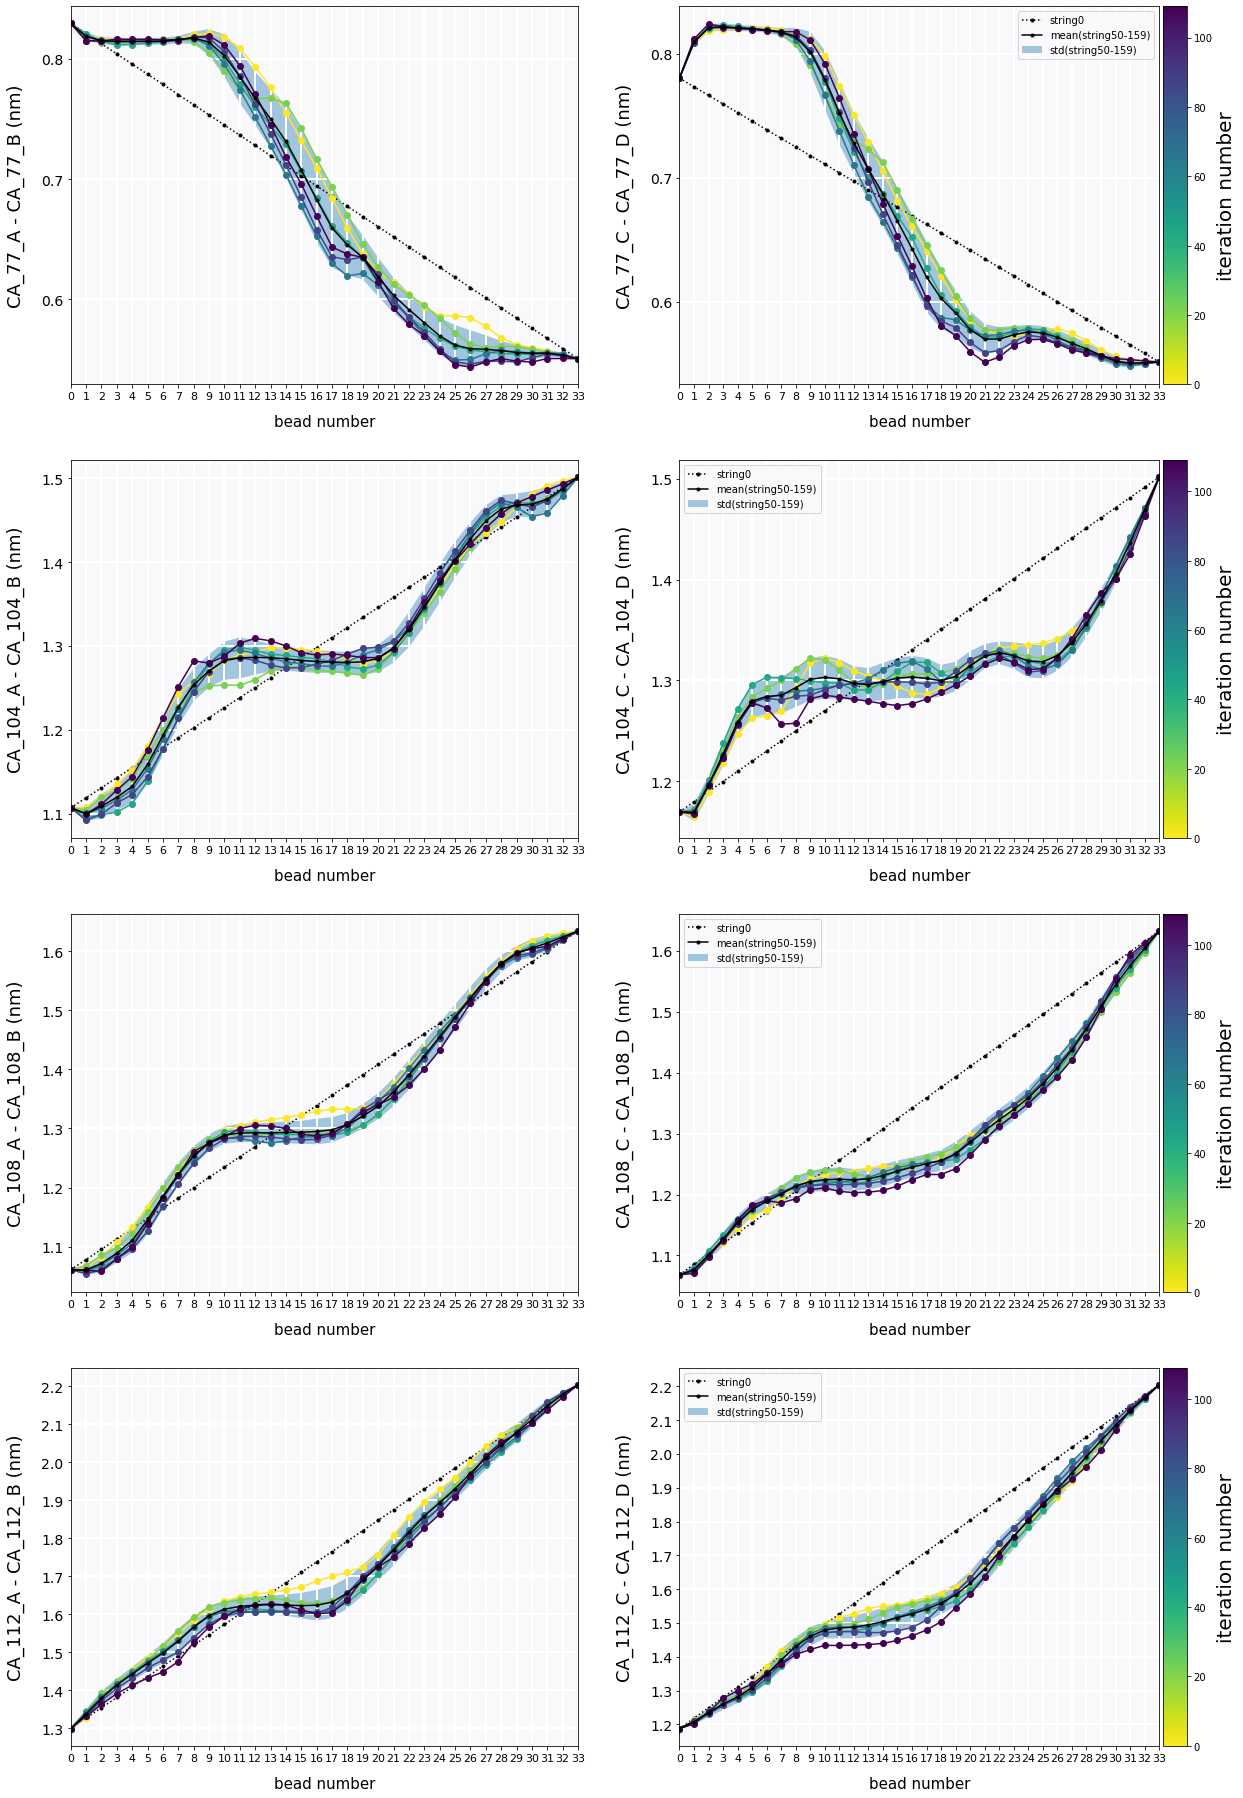

In [96]:
start_iteration = 50
n_average = 20


n_plots = strings.shape[1]
n_strings = strings.shape[0]
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(20, 8 * ceil(n_plots / 2)))
ax = ax.flatten()
cmap = plt.cm.viridis_r
n_colors = (n_strings - start_iteration) // n_average + 1
colors = cmap(np.linspace(0, 1, n_colors))  # yellow to blue
norm = mpl.colors.Normalize(vmin=0, vmax=n_strings - start_iteration)
for i, a in enumerate(ax):
    a.plot(strings[0, i, :], ls=":", marker=".", label="string0", color="k")
    for jj, j in enumerate(range(start_iteration, n_strings, n_average)):
        string = np.mean(strings[j : j + n_average, i, :], axis=0)
        a.plot(string, ls="-", marker="o", color=colors[jj])
    av = np.mean(strings[start_iteration:, i, :], axis=0)
    std = np.std(strings[start_iteration:, i, :], axis=0)
    a.fill_between(
        np.arange(len(av)),
        av + std,
        av - std,
        alpha=0.4,
        label=f"std(string{start_iteration}-{n_strings})",
    )
    a.plot(
        av,
        ls="-",
        marker=".",
        color="k",
        label=f"mean(string{start_iteration}-{n_strings})",
    )
    a.set_ylabel(
        f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]} (nm)",
        size=18,
        labelpad=16,
    )
    a.set_xlabel("bead number", size=15, labelpad=13)
    a.set_xlim(left=0, right=strings.shape[2] - 1)
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.xaxis.set_major_locator(MultipleLocator(1))
    a.yaxis.set_minor_locator(MultipleLocator(0.1))
    a.yaxis.set_major_locator(MultipleLocator(0.1))
    a.grid(which="minor")
    a.tick_params(axis="y", labelsize=14)
    a.tick_params(axis="x", labelsize=11)
    if i % 2 != 0:
        a.legend()
        cbar = colorbar(a, cmap, norm, "iteration number", 20)

## Evolution of beads with iterations

In this plot the trajectory of beads cvs over iterations is presented. You can observe if the beads are stable or drifting in some direction. In this plot you can choose one parameter, `n_rolling_average`, which determines the size of the rolling average window applied to smooth-out the noisyness.

In [81]:
colors.shape

(50, 4)

In [82]:
n_beads

34

In [86]:
np.arange(0, n_beads)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [85]:
cmap(np.arange(0, n_beads)).shape

(34, 4)

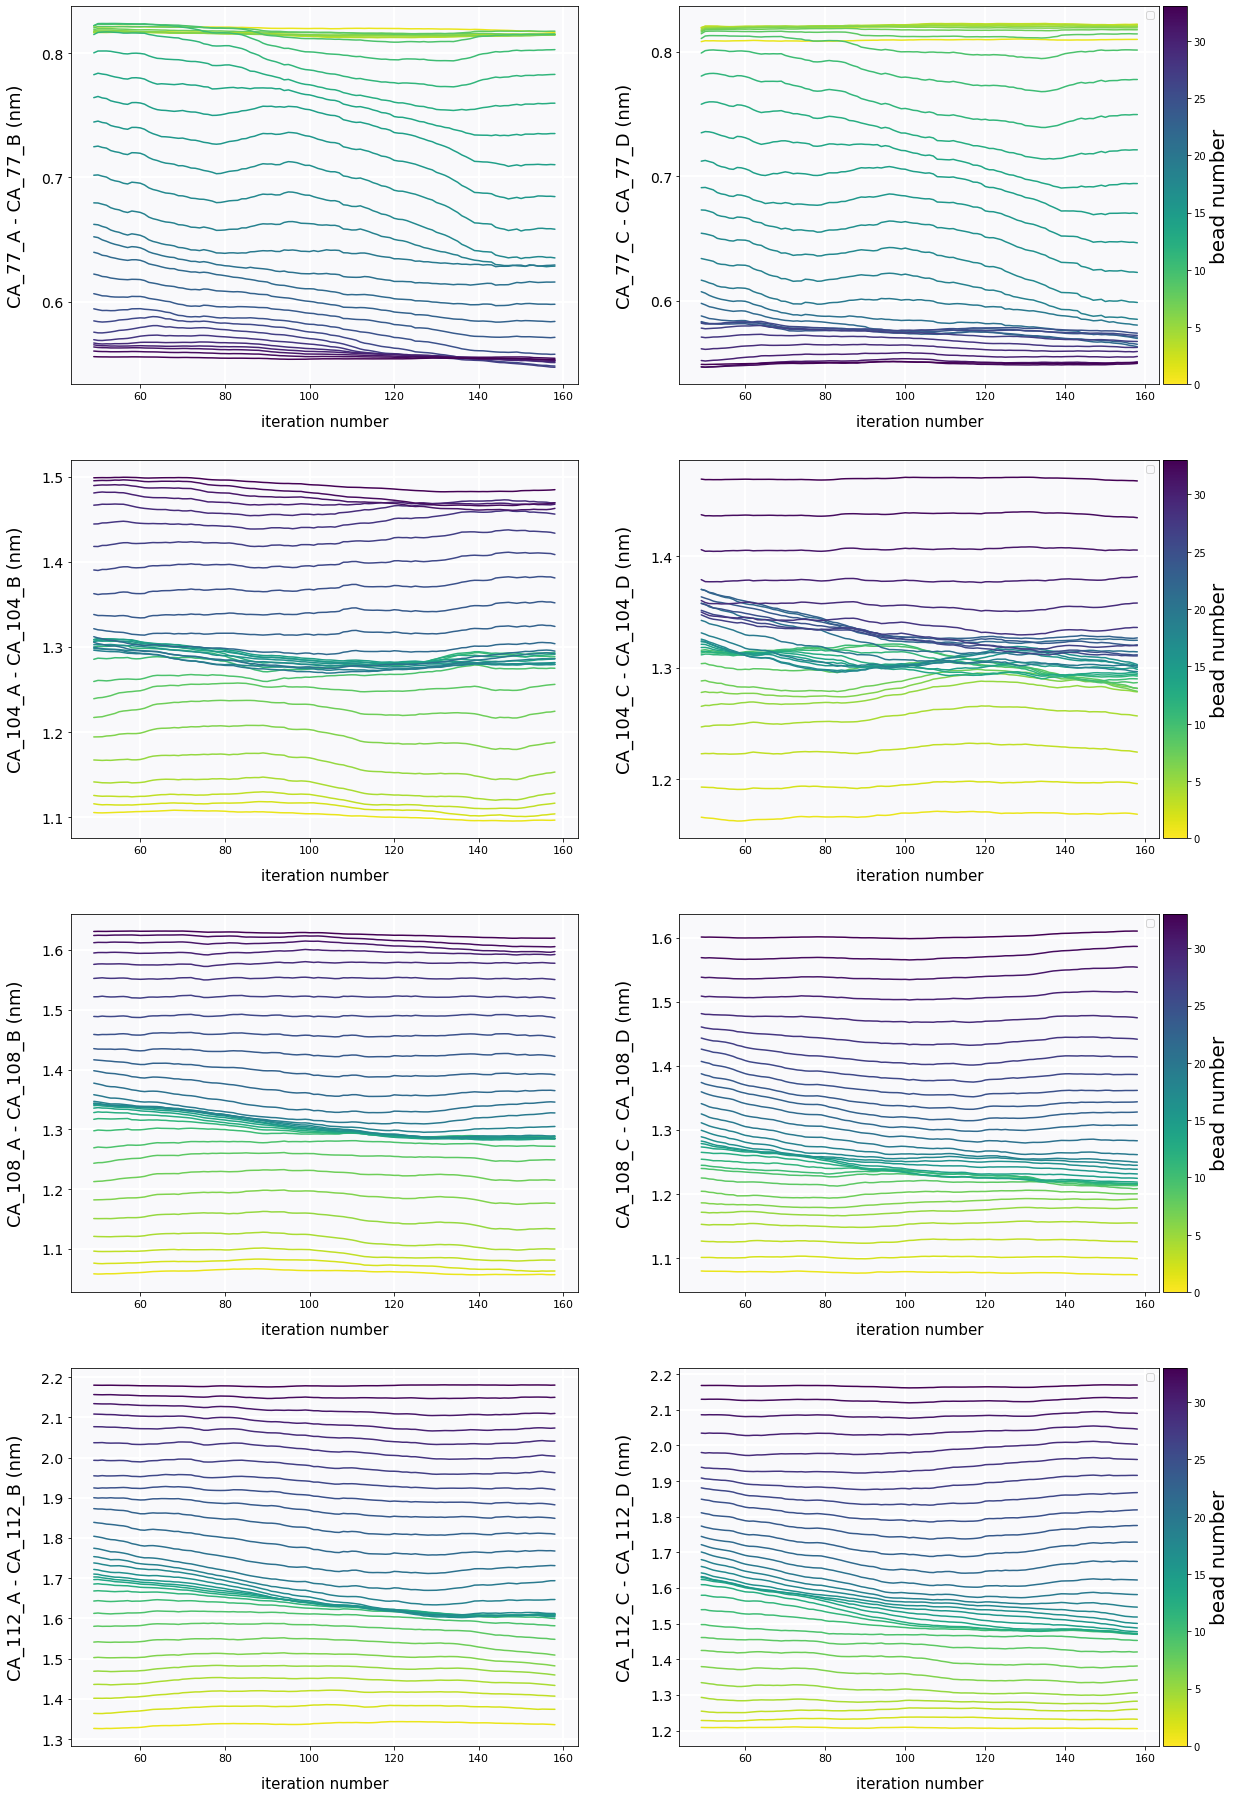

In [89]:
n_rolling_average = 20

n_strings = strings.shape[0]
n_cvs = strings.shape[1]
n_beads = strings.shape[2]
cmap = plt.cm.viridis_r
colors = cmap(np.linspace(0, 1, n_beads - 1))  # yellow to blue
norm = mpl.colors.Normalize(vmin=0, vmax=n_beads - 1)
fig, ax = plt.subplots(ceil(n_cvs / 2), 2, figsize=(20, 8 * ceil(n_cvs / 2)))
ax = ax.flatten()
for i in range(n_cvs):
    for j in range(1, n_beads - 1):
        y = np.convolve(strings[:, i, j], np.ones((N,)) / N, mode="valid")
        x = np.arange(n_strings)[N - 1 :]
        ax[i].plot(x, y, color=colors[j])
        ax[i].set_ylabel(
            f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]} (nm)",
            size=18,
            labelpad=16,
        )
        ax[i].set_xlabel("iteration number", size=15, labelpad=13)
        ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
        ax[i].yaxis.set_major_locator(MultipleLocator(0.1))
        ax[i].grid(which="minor")
        ax[i].tick_params(axis="y", labelsize=14)
        ax[i].tick_params(axis="x", labelsize=11)
    if i % 2 != 0:
        ax[i].legend()
        cbar = colorbar(ax[i], cmap, norm, "bead number", 20)

## Evolution over iterations of pairs of cvs
In this plot you can see the evolution of the string with iterations projected onto two chosen cvs

## Evolution over CVs that are a function of the cvs

If you are interested in studying the convergence of cvs that are a function of CVs (for example averaging over symmetrical distances). You can construct a `reduced_string` array in which cvs are a function of the cvs used for the string method. In the example bellow, we produce two cvs which are the mean of cvs used in the string method simulation. Then, similar plotting as before can be done. 

In addition if you are interested in the convergence of some other cv which is not a function of the cvs used in the string method you can also study them! Just extract the average value of that particular CV in the `md/*/*/restrained/traj_comp.xtc` for all the restrained simulation and shape them into an `reduced_string` numpy array with shape (n_iterations, n_cvs, n_beads).

If this sort of analysis is meaningless in your system, for example because the chosen cvs are very diagnostic, please ignore this section.

In [90]:
reduced_string = np.hstack(
    [
        np.mean(strings[:, 0:2, :], axis=1, keepdims=True),
        np.mean(strings[:, 6:, :], axis=1, keepdims=True),
    ]
)
reduced_string_labels = ["SF (nm)", "IG (nm)"]

In [103]:
from stringmethod.config import *
from stringmethod.postprocessing import *

In [106]:
def show(
    grid: np.array, free_energy: np.array, fe_cut_off: float = 100000000000000000.0
):
    from matplotlib import colors

    free_energy[free_energy > fe_cut_off] = np.nan
    phi = grid[:, 0]
    if free_energy.shape[1] == 1:
        plt.plot(phi, free_energy, "--o")
        plt.ylabel("Free Energy [kcal/mol]")
    else:
        psi = grid[:, 1]
        im = plt.contourf(
            phi,
            psi,
            free_energy.T,  # TODO should we take the transform of the matrix or not?
            levels=20,
            norm=colors.PowerNorm(gamma=1 / 3),
            cmap=plt.cm.rainbow,
        )
        cbar = plt.colorbar(im)
        cbar.set_label("[kcal/mol]")
        plt.xlabel("$\phi$ [degrees]")
        plt.ylabel("$\psi$ [degrees]")
    plt.tight_layout()
    plt.savefig("free_energy.svg", transparent=True)
    plt.show()

In [107]:
def compute_standard():
    config = load_config("config.json")

    ce = CvValueExtractor.from_config(
        config=config,
        # cv_coordinates= np.array([0,1]),
        first_iteration=100,  # Exclude the first iterations to let the system equilibrate.
    )
    ce.run()
    ce.persist()

    cv_coordinates = np.load("postprocessing/cv_coordinates.npy")
    # Convert from degrees to radians
    # cv_coordinates = cv_coordinates * np.pi / 180
    #
    # cv_coordinates = handle_periodicity(cv_coordinates)

    # Uncomment to only select one CV
    # cv_coordinates = np.mean(cv_coordinates[:,:,-2:], axis=2, keepdims=True)
    cv_coordinates = np.concatenate(
        [
            np.concatenate(
                [cv_coordinates[:, :, 0:1], cv_coordinates[:, :, 1:2]], axis=0
            ),
            np.concatenate(
                [cv_coordinates[:, :, 6:7], cv_coordinates[:, :, 7:8]], axis=0
            ),
        ],
        axis=2,
    )
    tc = TransitionCountCalculator.from_config(
        config=config,
        # You probably want to play around with n_grid_points.
        # It sets the resolution. Its optimal value depends on your swarm trajectory length and sample size
        n_grid_points=20,
        cv_coordinates=cv_coordinates,
    )
    tc.run()
    tc.persist()
    fc = FreeEnergyCalculator.from_config(
        config=config, grid=tc.grid, transition_count=tc.transition_count
    )
    fc.run()
    fc.persist()
    return tc.grid, fc.free_energy, cv_coordinates

In [108]:
def compute_standard():
    config = load_config("config.json")

    ce = CvValueExtractor.from_config(
        config=config,
        # cv_coordinates= np.array([0,1]),
        first_iteration=10,  # Exclude the first iterations to let the system equilibrate.
    )
    ce.run()
    ce.persist()

    cv_coordinates = np.load("postprocessing/cv_coordinates.npy")
    # Convert from degrees to radians
    # cv_coordinates = cv_coordinates * np.pi / 180
    #
    # cv_coordinates = handle_periodicity(cv_coordinates)

    # Uncomment to only select one CV
    # cv_coordinates = np.mean(cv_coordinates[:,:,-2:], axis=2, keepdims=True)
    cv_coordinates = np.concatenate(
        [
            np.mean(cv_coordinates[:, :, 0:2], axis=2, keepdims=True),
            np.mean(cv_coordinates[:, :, -2:], axis=2, keepdims=True),
        ],
        axis=2,
    )
    print(cv_coordinates.shape)
    tc = TransitionCountCalculator.from_config(
        config=config,
        # You probably want to play around with n_grid_points.
        # It sets the resolution. Its optimal value depends on your swarm trajectory length and sample size
        n_grid_points=15,
        cv_coordinates=cv_coordinates,
    )
    tc.run()
    tc.persist()
    fc = FreeEnergyCalculator.from_config(
        config=config, grid=tc.grid, transition_count=tc.transition_count
    )
    fc.run()
    fc.persist()
    return tc.grid, fc.free_energy, cv_coordinates

In [109]:
grid, free_energy, cv_coordinates = compute_standard()

2021-02-16 09:35:23 stringmethod-0-INFO: Remember to remove unfinished strings
2021-02-16 09:35:55 stringmethod-0-INFO: No output files found for iteration 145. Not looking further
(138240, 2, 2)
2021-02-16 09:36:01 stringmethod-0-WARNING: Found 52 accessible states, 173 inaccessible states and 0 states with no starting points.
2021-02-16 09:36:01 stringmethod-0-DEBUG: Converged with master equation after 23 iterations


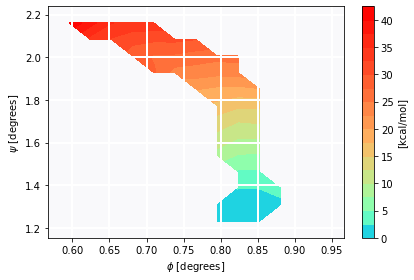

In [110]:
show(grid, free_energy)